In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import phik
from sklearn import datasets

# Dataset

In [29]:
data = datasets.load_breast_cancer()

Wisconsin Diagnostic Breast Cancer (WDBC) is a dataset about breast cancer tissue. The breast cancer tissue is extracted from patients with a technique called *Fine Needle Aspiration*. Its an invasive biopsy procedure that collects the tissue. Then, that tissue is placed under a microscoped and an image is taken. From those images, the nucleus of the individual cells are observed and distinct features are measured. The dataset consists of 357 benign and 212 malignant cancer samples, as seen in the barchart below. 

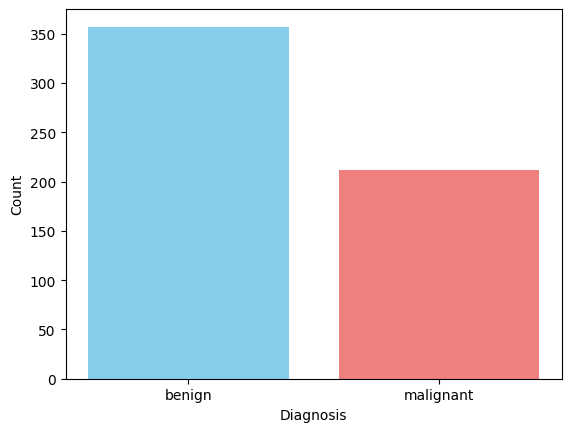

In [30]:
cnt = np.bincount(data.target)
plt.bar(data.target_names[::-1], cnt[::-1], color=['skyblue', 'lightcoral'])
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

There are 10 features that are observed, and each feature has 3 statistical features derived from it, bringing it to a total of 30 features. The statistical features are the mean value, the worst (largest) value and the standard error.

The features are listed below.

In [31]:
# original samples
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


The dataset is split into the train and test sets. The size of the test is 25% of the original dataset. The train set will be additionaly split with a k-fold cross validation.

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

D_train = pd.DataFrame(X_train.copy())
D_train.insert(0, 'diagnosis', y_train)

# Preprocessing

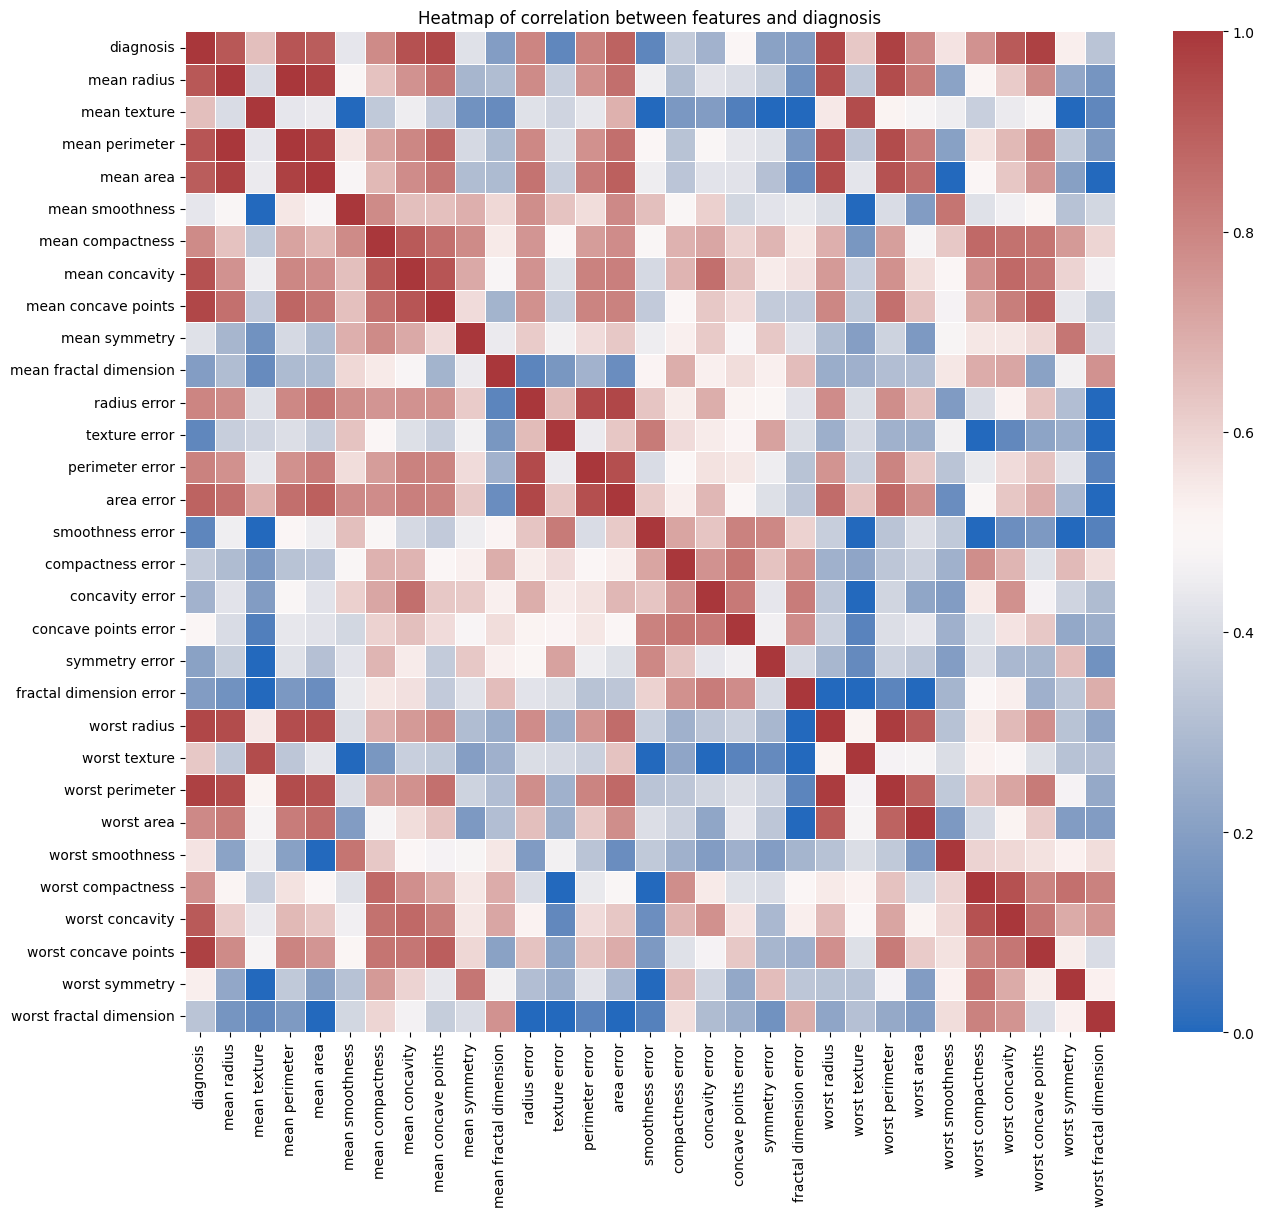

In [33]:
D_train = pd.DataFrame(X_train.copy())
D_train.insert(0, 'diagnosis', y_train)

#cor_matrix = D_train.corr()
cor_matrix_with_target = D_train.phik_matrix(interval_cols=D_train.columns)
cor_matrix_without_target = X_train.phik_matrix(interval_cols=X_train.columns)

plt.figure(figsize=(15, 13))
sns.heatmap(cor_matrix_with_target, cmap="vlag", linewidths=.5)  #, mask=np.triu(D_train_mean.corr()))
plt.title("Heatmap of correlation between features and diagnosis")
plt.show()

Features that are highly correlated with eachother may negatively impact our models and add no value to them, so we are removing highly correlated features.

In [34]:
drop_cutoff = 0.95

upper_tri = cor_matrix_without_target.abs().where(
    np.triu(np.ones(cor_matrix_without_target.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > float(drop_cutoff))]

print(list(to_drop))

['mean perimeter', 'mean area', 'perimeter error', 'area error', 'worst perimeter']


In [35]:
X_train = X_train.drop(list(to_drop), axis=1)
X_test = X_test.drop(list(to_drop), axis=1)
D_train = D_train.drop(list(to_drop), axis=1)

X_train.shape

(426, 25)

25 features is still a lot of features for our models so we will subset the features and take those most correlated with the diagnosis. The barchart below shows the correlation of the features with the diagnosis.

<Figure size 1000x500 with 0 Axes>

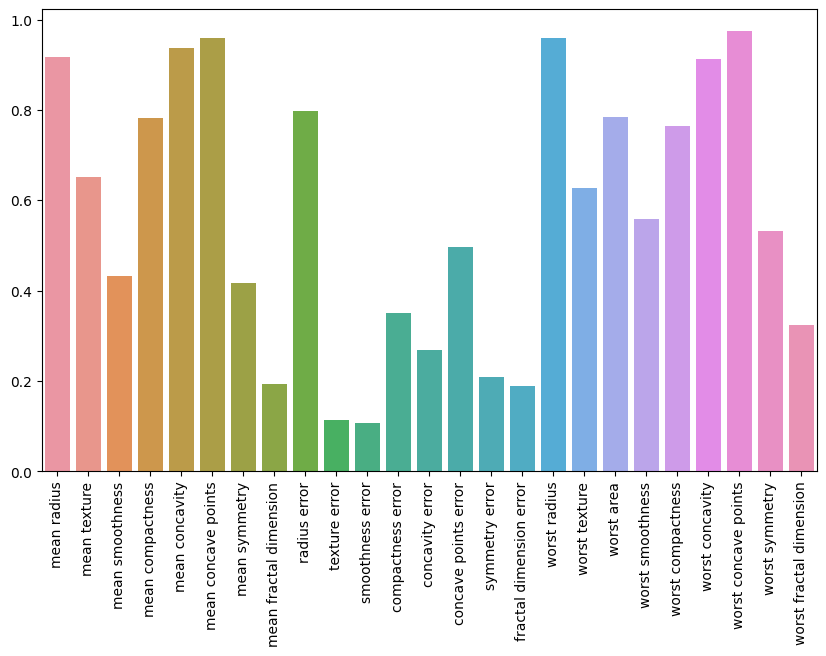

In [36]:
plt.figure(figsize=(10, 5))

corr_with_target = D_train.phik_matrix(interval_cols=X_train.columns)['diagnosis'].drop(labels=['diagnosis'])

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
plt.xticks(rotation=90)
plt.show()

For the feature selection we are using an algorithm called Sequential Feature Selector. It is a greedy search algorithm that starts with 0 features, and then it iteratively searches for and adds features that maximise the cross-validated score of an estimator. For the estimator we are using Logistic Regression as it is a commonly used for this purpose.

In [38]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

num_features = 6

X_best = SequentialFeatureSelector(estimator=LogisticRegression(max_iter=500), n_features_to_select=num_features, cv=10,
                                   direction='forward', n_jobs=4).fit(X_train, y_train)
mask = X_best.get_support()
best_features = []
for curr_bool, feature in zip(mask, X_train.columns):
    if curr_bool:
        best_features.append(feature)

print(f"Best features are: {best_features}")

Best features are: ['mean smoothness', 'mean compactness', 'worst radius', 'worst texture', 'worst compactness', 'worst concavity']


In [39]:
X_train = X_train[X_train.columns[X_best.get_support(indices=True)]]
X_test = X_test[X_test.columns[X_best.get_support(indices=True)]]

X_train.shape

(426, 6)

We apply a scaler to standardize the features. 

In [42]:
from sklearn.preprocessing import StandardScaler

sclr = StandardScaler()
X_train_s = sclr.fit_transform(X_train)
X_test_s = sclr.fit_transform(X_test)

In [56]:
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression

For logistic regression, we are considering different values of C: the inverse of regularization strength. We will consider 3 different models, with values of C equal to 0.8, 1 (default) and 1.25.

In [43]:
from sklearn.model_selection import cross_validate
Cs = [0.8, 1, 1.25]

for regularization_strength in Cs:
    print(f"Performing experiment with C = {regularization_strength}")
    model_logreg = LogisticRegression(C = regularization_strength, random_state = 5)
    scores2 = cross_validate(model_logreg, X_train_s, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'])
    print(f'Fit time: {scores2["fit_time"].sum()}\nScore_time: {scores2["score_time"].sum()}')
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores2['test_accuracy'].mean(), scores2['test_accuracy'].std() * 2))
    print("Precision: %0.3f (+/- %0.3f)" % (scores2['test_precision'].mean(), scores2['test_precision'].std() * 2))
    print("Recall: %0.3f (+/- %0.3f)" % (scores2['test_recall'].mean(), scores2['test_recall'].std() * 2))
    print("F1: %0.3f (+/- %0.3f)\n" % (scores2['test_f1'].mean(), scores2['test_f1'].std() * 2))



Performing experiment with C = 0.8
Fit time: 0.02426290512084961
Score_time: 0.027467966079711914
Accuracy: 0.960 (+/- 0.028)
Precision: 0.961 (+/- 0.055)
Recall: 0.978 (+/- 0.028)
F1: 0.969 (+/- 0.021)

Performing experiment with C = 1
Fit time: 0.02360081672668457
Score_time: 0.031246185302734375
Accuracy: 0.960 (+/- 0.024)
Precision: 0.965 (+/- 0.058)
Recall: 0.974 (+/- 0.038)
F1: 0.969 (+/- 0.018)

Performing experiment with C = 1.25
Fit time: 0.020575761795043945
Score_time: 0.024242401123046875
Accuracy: 0.958 (+/- 0.024)
Precision: 0.965 (+/- 0.057)
Recall: 0.970 (+/- 0.045)
F1: 0.967 (+/- 0.018)



Judging by the F1 performance, the logistic regression model with C = 1 performed the best (lower variance is valued after the score itself)

In [61]:
model_logreg = LogisticRegression(C = 1, random_state = 5)
model_logreg.fit(X_train_s, y_train)
preds = model_logreg.predict(X_test_s)
logreg_report = classification_report(y_test, preds)
logreg_confusion_matrix = confusion_matrix(y_test, preds)
print(logreg_report)
print(logreg_confusion_matrix)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        55
           1       0.97      1.00      0.98        88

    accuracy                           0.98       143
   macro avg       0.98      0.97      0.98       143
weighted avg       0.98      0.98      0.98       143

[[52  3]
 [ 0 88]]


# Neural Network

# Decision Trees

## Random Forest Classifier

We are only testing models with different n_estimators because the dataset is already preprocessed to have only 6 features.

In [44]:
from sklearn.ensemble import RandomForestClassifier

estimators = [50, 100, 300]

for est in estimators:
    print(f"Performing experiment with n_estimators = {est}")
    model_rfc = RandomForestClassifier(n_estimators = est, random_state = 5)
    scores2 = cross_validate(model_rfc, X_train_s, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'])
    print(f'Fit time: {scores2["fit_time"].sum()}\nScore_time: {scores2["score_time"].sum()}')
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores2['test_accuracy'].mean(), scores2['test_accuracy'].std() * 2))
    print("Precision: %0.3f (+/- %0.3f)" % (scores2['test_precision'].mean(), scores2['test_precision'].std() * 2))
    print("Recall: %0.3f (+/- %0.3f)" % (scores2['test_recall'].mean(), scores2['test_recall'].std() * 2))
    print("F1: %0.3f (+/- %0.3f)\n" % (scores2['test_f1'].mean(), scores2['test_f1'].std() * 2))



Performing experiment with n_estimators = 50
Fit time: 0.48288798332214355
Score_time: 0.059667110443115234
Accuracy: 0.951 (+/- 0.028)
Precision: 0.964 (+/- 0.057)
Recall: 0.959 (+/- 0.044)
F1: 0.961 (+/- 0.021)

Performing experiment with n_estimators = 100
Fit time: 1.2573199272155762
Score_time: 0.15228700637817383
Accuracy: 0.960 (+/- 0.024)
Precision: 0.961 (+/- 0.054)
Recall: 0.978 (+/- 0.043)
F1: 0.969 (+/- 0.018)

Performing experiment with n_estimators = 300
Fit time: 2.937645196914673
Score_time: 0.21810698509216309
Accuracy: 0.960 (+/- 0.049)
Precision: 0.961 (+/- 0.072)
Recall: 0.978 (+/- 0.028)
F1: 0.969 (+/- 0.036)



We choose n_estimators = 100 as the best model. The f1 values of n_estimators = 100 and n_estimators = 300 are equal but the prior has lower variance. Also, the time to train and test is lower.

In [59]:
model_rfc = RandomForestClassifier(n_estimators = 100, random_state = 5)
model_rfc.fit(X_train_s, y_train)
preds = model_rfc.predict(X_test_s)
rfc_report = classification_report(y_test, preds)
rfc_confusion_matrix = confusion_matrix(y_test, preds)
print(rfc_report)
print(rfc_confusion_matrix)


              precision    recall  f1-score   support

           0       1.00      0.91      0.95        55
           1       0.95      1.00      0.97        88

    accuracy                           0.97       143
   macro avg       0.97      0.95      0.96       143
weighted avg       0.97      0.97      0.96       143

[[50  5]
 [ 0 88]]


## XGBoost 

In [45]:
from xgboost import XGBClassifier

estimators = [50, 100, 300]
max_depths = [4, 6, 8]
lambdas = [0.8, 1, 1.25]

for d in max_depths:
    for la in lambdas:
        for est in estimators:
            print(f"Performing experiment with max_depth = {d}, lambda = {la}, n_estimators = {est}")
            model_xgb = XGBClassifier(max_depth = d, reg_lambda = la, n_estimators = est, random_state = 5)
            scores2 = cross_validate(model_xgb, X_train_s, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'])
            print(f'Fit time: {scores2["fit_time"].sum()}\nScore_time: {scores2["score_time"].sum()}')
            print("Accuracy: %0.3f (+/- %0.3f)" % (scores2['test_accuracy'].mean(), scores2['test_accuracy'].std() * 2))
            print("Precision: %0.3f (+/- %0.3f)" % (scores2['test_precision'].mean(), scores2['test_precision'].std() * 2))
            print("Recall: %0.3f (+/- %0.3f)" % (scores2['test_recall'].mean(), scores2['test_recall'].std() * 2))
            print("F1: %0.3f (+/- %0.3f)\n" % (scores2['test_f1'].mean(), scores2['test_f1'].std() * 2))

Performing experiment with max_depth = 4, lambda = 0.8, n_estimators = 50
Fit time: 0.20342516899108887
Score_time: 0.05387091636657715
Accuracy: 0.953 (+/- 0.054)
Precision: 0.961 (+/- 0.070)
Recall: 0.966 (+/- 0.050)
F1: 0.963 (+/- 0.041)

Performing experiment with max_depth = 4, lambda = 0.8, n_estimators = 100
Fit time: 0.23862338066101074
Score_time: 0.05042219161987305
Accuracy: 0.955 (+/- 0.057)
Precision: 0.961 (+/- 0.070)
Recall: 0.970 (+/- 0.056)
F1: 0.965 (+/- 0.043)

Performing experiment with max_depth = 4, lambda = 0.8, n_estimators = 300
Fit time: 0.6822059154510498
Score_time: 0.04484224319458008
Accuracy: 0.955 (+/- 0.057)
Precision: 0.961 (+/- 0.070)
Recall: 0.970 (+/- 0.056)
F1: 0.965 (+/- 0.043)

Performing experiment with max_depth = 4, lambda = 1, n_estimators = 50
Fit time: 0.09987950325012207
Score_time: 0.042943716049194336
Accuracy: 0.953 (+/- 0.054)
Precision: 0.961 (+/- 0.070)
Recall: 0.966 (+/- 0.050)
F1: 0.963 (+/- 0.041)

Performing experiment with max_d

Experiment with max_depth = 4, lambda = 0.8, n_estimators = 100 was the best. It was tied for f1 score with 3 other models, but this model had the fastest training and scoring time, and because of it is chosen as the best one.

In [60]:
model_xgb = XGBClassifier(max_depth = 4, reg_lambda = 0.8, n_estimators = 100, random_state = 5)
model_xgb.fit(X_train_s, y_train)
preds = model_xgb.predict(X_test_s)
xgb_report = classification_report(y_test, preds)
xgb_confusion_matrix = confusion_matrix(y_test, preds)
print(xgb_report)
print(xgb_confusion_matrix)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        55
           1       0.97      1.00      0.98        88

    accuracy                           0.98       143
   macro avg       0.98      0.97      0.98       143
weighted avg       0.98      0.98      0.98       143

[[52  3]
 [ 0 88]]
